Model adapted from TAMUCC Beto Estrada by Nevena Cail

Model Training: Handles model training and model evalutation for water level predictions for Florida's Virginia Key tide station

2/24/2025

There are ways to mount your actual drive, but won't cover that here

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

To get to the data, download the following CSV files from Google Drive and place them in the download folder or the desktop of your local computer:

(1) 8723214_VirginiaKey_TrainingSplit.csv
(2) 8723214_VirginiaKey_ValidationSplit.csv
(3) 8723214_VirginiaKey_TestSplit.csv

Upload the three files to CoLab using the following steps:

Click on the folder icon on the left sidebar. Click on the "content folder" to make sure the uploaded files will be stored in that folder. You will need to upload again these files for each session. Click on the "Upload to Session" button above the folders and select the files from your local machine. After uploading, you can access the files by their filenames.

These files have the following data, each for a different set of dates for the training and testing data:
- Time stamp MM/DD/YYYY HH:MM
- Water level in meter
- uwind in m/s or East-West wind component
- vwind in m/s or North-South wind component

# Import necessary libraries

In [ ]:
# General Purpose
from datetime import datetime

# Path Handling
import os
from os.path import exists

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

# Data manipulation
import pandas as pd

# Machine Learning
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, Dropout
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, mean_absolute_percentage_error

# Read in training, validation, and testing sets
Training Years: 1998-2004, 2006-2016, and 2018

Validation Years: 2019-2020

Testing Years: 2005, 2017, 2021-2023

In [ ]:
# NOTE:: Setting parse_dates=True will attempt to parse the index
# as a datetime. It automatically attempts to infer the format of the datetime.
training_csv_path = '8723214_VirginiaKey_TrainingSplit.csv'
df_training = pd.read_csv(training_csv_path, index_col=0, parse_dates=True)

validation_csv_path = '8723214_VirginiaKey_ValidationSplit.csv'
df_validation = pd.read_csv(validation_csv_path, index_col=0, parse_dates=True)

testing_csv_path = f'8723214_VirginiaKey_TestSplit.csv'
df_testing = pd.read_csv(testing_csv_path , index_col=0, parse_dates=True)

df_training

,wl,uwind,vwind
1998-01-01 00:00:00,-0.458,0.779423,-4.500000e-01
1998-01-01 01:00:00,-0.316,1.950511,-1.218814e+00
1998-01-01 02:00:00,-0.202,3.046894,-2.743435e+00
1998-01-01 03:00:00,-0.128,2.202621,-2.720011e+00
1998-01-01 04:00:00,-0.147,2.420679,-4.028686e+00
...,...,...,...
2018-12-31 19:00:00,-0.164,-4.383257,-3.834853e-01
2018-12-31 20:00:00,-0.067,-4.056888,-1.087040e+00
2018-12-31 21:00:00,0.022,-3.600000,-2.200000e-16
2018-12-31 22:00:00,0.061,-2.761515,-1.172193e+00


In [ ]:
# Show info about the index as well as the different columns in the DataFrame
df_training.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153456 entries, 1998-01-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   wl      153456 non-null  float64
 1   uwind   153456 non-null  float64
 2   vwind   153456 non-null  float64
dtypes: float64(3)
memory usage: 4.7 MB


# Model evaluation functions
These functions will be used throughout the notebook
- Calculate model loss
- Calculate Central Frequency, Mean Squared Error, Mean Absolute Error, and R-squared
- Plot time series of model predictions vs observations
- Plot model loss

In [ ]:
def calculate_central_frequency_percentage(testing_label_array, predictions, cm):
  """Find the percentage of predictions with a central frequency (CF) of less than
  or equal to a given number of centimeters (cm)

	Args:
        testing_label_array (array): Testing labels

        predictions (array): Model predictions

        cm (int): Number of centimeters

	Returns:
		(float): central frequency (CF) percentage
	"""
  less_than_cm_counter = 0

  # Convert cm to m
  cm_to_m = cm / 100

  for index, prediction in enumerate(predictions):
    if abs(testing_label_array[index] - prediction) <= cm_to_m:
      less_than_cm_counter += 1

  cf_percentage = (less_than_cm_counter / len(predictions)) * 100

  return cf_percentage


def evaluate_model(model, testing_input_array, testing_label_array):
  """Calculates loss, makes predictions, and calculates Central Frequency (CF),
  Mean Squared Error (MSE), Root Mean Squared Error(RMSE), Mean Absolute Error (MAE),
  Median Absolute Error, and R-squared (R2)

	Args:
        model (tf.keras.model): The trained model

        testing_input_array (array): Testing inputs

        testing_label_array (array): Testing labels
	"""
  print("Calculating Loss:")
  test_loss = model.evaluate(testing_input_array, testing_label_array, batch_size = len(testing_input_array))

  print("Loss:", test_loss)


  print("\nGenerating output predictions with model:")
  predictions = model.predict(testing_input_array, batch_size = len(testing_input_array))

  # Calculate evaluation metrics
  cf_15cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 15)
  cf_5cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 5)
  cf_1cm_percentage = calculate_central_frequency_percentage(testing_label_array, predictions, 1)
  mse = mean_squared_error(testing_label_array, predictions)
  rmse = root_mean_squared_error(testing_label_array, predictions)
  mae = mean_absolute_error(testing_label_array, predictions)
  medae = median_absolute_error(testing_label_array, predictions)
  r2 = r2_score(testing_label_array, predictions)

  print("\nCentral Frequency Percentage 15cm:", cf_15cm_percentage)
  print("\nCentral Frequency Percentage 5cm:", cf_5cm_percentage)
  print("\nCentral Frequency Percentage 1cm:", cf_1cm_percentage)
  print("Mean Squared Error:", mse)
  print("Root Mean Squared Error:", rmse)
  print("Mean Absolute Error:", mae)
  print("Median Absolute Error:", medae)
  print("R-squared:", r2)


def plot_model_predictions(testing_labels, predictions, title, x_label, y_label, plot_file_name, legend_location = 'best'):
  """Plots model predictions and compares to testing labels to evaluate the model performance

	Args:
        testing_labels (list): list of testing labels

        predictions (list): list of model predictions

        title (string): plot title

        x_label (string): x-axis label

        y_label (string): y-axis label

        plot_file_name (string): file name for plot. Must have appropriate image extension (eg. 'png', 'pdf', 'svg', ...)

        legend_location (string): 'best' (Axes only), 'upper right', 'upper left', 'lower left', 'lower right', 'right',
                                  'center left', 'center right', 'lower center', 'upper center', 'center'. Defaults to 'best'
	"""
  fig, ax = plt.subplots(1, figsize=(25, 10))

  # Plot the observations and model predictions on the same plot
  plt.plot(testing_labels, label='Observed')
  plt.plot(predictions, label='Predicted')

  plt.title(title, fontsize=30)

  ax.set_xlabel(x_label, fontsize=22)
  ax.set_ylabel(y_label, fontsize=22)

  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

  plt.legend(fontsize = 20, loc = legend_location)

  plt.savefig(plot_file_name, bbox_inches='tight')

  plt.show()

  plt.close()


def plot_model_loss(model_history, plot_file_name, legend_location = 'best'):
  """Plots model training loss and validation loss on the same plot

	Args:
        model_history (keras.src.callbacks.History): model history

        plot_file_name (string): file name for plot. Must have appropriate image extension (eg. 'png', 'pdf', 'svg', ...)

        legend_location (string): 'best' (Axes only), 'upper right', 'upper left', 'lower left', 'lower right', 'right',
                                  'center left', 'center right', 'lower center', 'upper center', 'center'. Defaults to 'best'
	"""
  fig, ax = plt.subplots(1, figsize=(25, 10))

  # Plot training & validation loss values
  plt.plot(model_history.history['loss'])
  plt.plot(model_history.history['val_loss'])

  lowest_val_loss = min(model_history.history['val_loss'])
  best_epoch = model_history.history['val_loss'].index(lowest_val_loss)

  ax.axvline(x = best_epoch, color='r', linestyle='--')

  plt.title('Model loss', fontsize=30)

  ax.set_xlabel('Epoch', fontsize=22)
  ax.set_ylabel('Loss', fontsize=22)

  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

  plt.legend(['Train', 'Validation', 'Lowest Validation Loss'], fontsize = 20, loc = legend_location)

  plt.savefig(plot_file_name, bbox_inches='tight')

  plt.show()

  plt.close()


def plot_interactive_time_series(dfs, title, x_label, y_label, plot_file_name, mode = 'lines', show = True):
  """Plots list of pandas dataframes datetime data on the same interactive Plotly chart.
  Saves the resulting plot in the user-specified path.

	Args:
        dfs (list): list of pandas dataframes. Must contain columns: 'data', 'dash_style', 'line_color', and 'legend_label'

        title (string): plot title

        x_label (string): x-axis label

        y_label (string): y-axis label

        plot_file_name (string): file name for plot. Must have appropriate image extension ('.html')

        mode (string): Choose between 'markers', 'lines', and 'lines+markers'. Defaults to 'lines'

        show (bool): Whether or not to display the plot on the screen. If the plot contains a large amount of data it
                     is recommended to set show = False. The code may crash if you do not
	"""
  fig = go.Figure()

  for df in dfs:
    fig.add_trace(go.Scatter(x = df.index, y = df['data'], mode = mode, line = dict(dash=df['dash_style'][0], color=df['line_color'][0]), name = df['legend_label'][0]))

  fig.update_layout(
      title=go.layout.Title(
                    text = title,
                    font=dict(
                        family = 'Arial',
                        size = 20,
                        color = 'black'
                    ),
                    xref = 'paper',
                    x = 0.5
      ),

      xaxis=dict(title = x_label),
      yaxis=dict(title = y_label),
      hovermode='x unified'
  )

  fig.update_traces(connectgaps=False)

  fig.write_html(plot_file_name, include_plotlyjs='cdn')

  if show is True:
    fig.show()

# Functions to create input & output arrays
Will be used further below

In [ ]:
def create_lagged_columns(df, target_column, lag_range):
    """
    Adds lagged columns for a target column over a specified range of lags.

    Args:
        df (pd.DataFrame): The input DataFrame.

        target_column (str): The column to create lagged values for.

        lag_range (tuple): A tuple (start, finish) representing the range of lags.
                           Negative values are past lags, positive values are future.

    Returns:
        pd.DataFrame: A DataFrame with added lagged columns.
    """
    for lag in range(lag_range[0], lag_range[1] + 1):  # Include upper bound of range
        if lag != 0:  # Avoid creating a lag for 0 as it's the same as the original column

            # NOTE:: For the shift itself, the sign of the lag is flipped.
            # Reason: Shift treats the lags differently compared to how we treat them.
            # For example: When we ask for a shift of -24, we want the values 24 hours in the past.
            # However, shift will make it such that it instead gives you the values 24 hours in the future.
            # So, by flipping the sign the user will receive their desired result.
            df[f'{target_column}_t{"" if lag < 0 else "+"}{lag}'] = df[target_column].shift(-lag)

    return df


def extract_time_index(col_name):
    # Extracts the lag hour of the given column based on the attached suffix
    # Used for ordering the input columns
    if '_t' in col_name:
        # Extract the number after 't'
        return int(col_name.split('_t')[-1].replace('+', ''))
    return 0


def order_input_arrays(df, column_prefixes):
  # Sort columns based on given column prefixes
  sorted_columns = []
  for column_prefix in column_prefixes:
    sorted_columns = sorted_columns + sorted([col for col in df.columns if col.startswith(column_prefix)], key=extract_time_index)

  df_ordered = df[sorted_columns]

  return df_ordered


def extract_input_output_arrays(df, job_specification):
  """
  Here a dictionary is created for the given dataset. This dictionary contains:
  - The input array
  - The output array
  - And the original datetime indices for plotting the interactive time series later

  Args:
        df (pd.DataFrame): DataFrame containing dataset.

        job_specification (dict): Dictionary containing the job specification

  Returns:
      dict: Dictionary containing the input array, output array, and datetime index
  """
  input_specifications = job_specification['input_specifications']
  target_column = job_specification['target_column']

  # Here the lagged columns are created in the dataframe based on the given input specifications
  for input in input_specifications:
      df = create_lagged_columns(df, input['column'], input['lag_range'])

  # Drop any NaNs (dates at the beginning/end of the dataset will not have previous inputs/target values to use)
  df.dropna(inplace=True)

  # Extract the target array before removing later
  target_array = df[target_column].values

  # Save datetimes of df for plotting purposes later
  datetime_index = df.index

  # Remove the target column from df before creating ordered input arrays
  df_inputs = df.drop(columns=[target_column])

  column_prefixes = job_specification['column_prefixes']

  # Input columns are ordered based on the order of the given column prefixes
  df_inputs_ordered = order_input_arrays(df_inputs, column_prefixes)

  input_array = df_inputs_ordered.values

  input_output_dict = {'input_array': input_array,
                       'target_array': target_array,
                       'datetime_index': datetime_index}

  return input_output_dict

# Creating lagged columns for inputs / target variable (Example)

## Create lagged input column of the water level 24 hrs ago (wl_t-24)

In [ ]:
df_training_copy = df_training.copy()

# 24 hrs ago based on the current datetime (index of current row)
lag = -24

# We call it "-24", but we are actually shifting the index 24 spots "forward".
# Hence a positive 24 is actually passed to the shift method.
df_training_copy[f'wl_t-24'] = df_training_copy['wl'].shift(-lag)

df_training_copy

,wl,uwind,vwind,wl_t-24
1998-01-01 00:00:00,-0.458,0.779423,-4.500000e-01,NaN
1998-01-01 01:00:00,-0.316,1.950511,-1.218814e+00,NaN
1998-01-01 02:00:00,-0.202,3.046894,-2.743435e+00,NaN
1998-01-01 03:00:00,-0.128,2.202621,-2.720011e+00,NaN
1998-01-01 04:00:00,-0.147,2.420679,-4.028686e+00,NaN
...,...,...,...,...
2018-12-31 19:00:00,-0.164,-4.383257,-3.834853e-01,-0.110
2018-12-31 20:00:00,-0.067,-4.056888,-1.087040e+00,-0.024
2018-12-31 21:00:00,0.022,-3.600000,-2.200000e-16,0.013
2018-12-31 22:00:00,0.061,-2.761515,-1.172193e+00,-0.070


## Create target column of the water level 24 hrs in the future (wl_t+24)

In [ ]:
# 24 hrs in the future based on the current datetime (index of current row)
lag = 24

# Same as before, this time a negative 24 is actually passed to shift
df_training_copy[f'wl_t+24'] = df_training_copy['wl'].shift(-lag)

df_training_copy

,wl,uwind,vwind,wl_t-24,wl_t+24
1998-01-01 00:00:00,-0.458,0.779423,-4.500000e-01,NaN,-0.593
1998-01-01 01:00:00,-0.316,1.950511,-1.218814e+00,NaN,-0.425
1998-01-01 02:00:00,-0.202,3.046894,-2.743435e+00,NaN,-0.279
1998-01-01 03:00:00,-0.128,2.202621,-2.720011e+00,NaN,-0.142
1998-01-01 04:00:00,-0.147,2.420679,-4.028686e+00,NaN,-0.054
...,...,...,...,...,...
2018-12-31 19:00:00,-0.164,-4.383257,-3.834853e-01,-0.110,NaN
2018-12-31 20:00:00,-0.067,-4.056888,-1.087040e+00,-0.024,NaN
2018-12-31 21:00:00,0.022,-3.600000,-2.200000e-16,0.013,NaN
2018-12-31 22:00:00,0.061,-2.761515,-1.172193e+00,-0.070,NaN


## Drop any NaNs (dates at the beginning/end of the dataset may have certain inputs that don't exist)

In [ ]:
df_training_copy.dropna(inplace=True)

df_training_copy

,wl,uwind,vwind,wl_t-24,wl_t+24
1998-01-02 00:00:00,-0.593,-5.117260,-5.886735,-0.458,-0.648
1998-01-02 01:00:00,-0.425,-2.472183,-4.114403,-0.316,-0.527
1998-01-02 02:00:00,-0.279,-6.264090,-5.445290,-0.202,-0.364
1998-01-02 03:00:00,-0.142,-8.448664,-4.120689,-0.128,-0.222
1998-01-02 04:00:00,-0.054,-8.511112,-2.602108,-0.147,-0.101
...,...,...,...,...,...
2018-12-30 19:00:00,-0.110,-3.474925,-1.770563,-0.037,-0.164
2018-12-30 20:00:00,-0.024,-3.178611,-1.690098,-0.012,-0.067
2018-12-30 21:00:00,0.013,-3.155166,-2.292362,-0.097,0.022
2018-12-30 22:00:00,-0.070,-2.834364,-2.378314,-0.226,0.061


## Extract target array

In [ ]:
target_array = df_training_copy['wl_t+24'].values

target_array

array([-0.648, -0.527, -0.364, ...,  0.022,  0.061, -0.021])

In [ ]:
target_array.shape

(153408,)

## Drop the target column from df before creating ordered input arrays

In [ ]:
# Drop the target column from df before creating ordered input arrays
df_inputs = df_training_copy.drop(columns=['wl_t+24'])

df_inputs

,wl,uwind,vwind,wl_t-24
1998-01-02 00:00:00,-0.593,-5.117260,-5.886735,-0.458
1998-01-02 01:00:00,-0.425,-2.472183,-4.114403,-0.316
1998-01-02 02:00:00,-0.279,-6.264090,-5.445290,-0.202
1998-01-02 03:00:00,-0.142,-8.448664,-4.120689,-0.128
1998-01-02 04:00:00,-0.054,-8.511112,-2.602108,-0.147
...,...,...,...,...
2018-12-30 19:00:00,-0.110,-3.474925,-1.770563,-0.037
2018-12-30 20:00:00,-0.024,-3.178611,-1.690098,-0.012
2018-12-30 21:00:00,0.013,-3.155166,-2.292362,-0.097
2018-12-30 22:00:00,-0.070,-2.834364,-2.378314,-0.226


## Order the columns in the same order that you want them to go as inputs to the model

Semaphore prefers this order:

Input Node 1: wl-1

Input Node 2: wl

Input Node 3: uwind-1

Input Node 4: uwind

Input Node 5: vwind-1

Input Node 6: vwind

In [ ]:
column_prefixes = ['wl', 'uwind', 'vwind']

# Input columns are ordered based on the order of the given column prefixes
df_inputs_ordered = order_input_arrays(df_inputs, column_prefixes)

df_inputs_ordered

,wl_t-24,wl,uwind,vwind
1998-01-02 00:00:00,-0.458,-0.593,-5.117260,-5.886735
1998-01-02 01:00:00,-0.316,-0.425,-2.472183,-4.114403
1998-01-02 02:00:00,-0.202,-0.279,-6.264090,-5.445290
1998-01-02 03:00:00,-0.128,-0.142,-8.448664,-4.120689
1998-01-02 04:00:00,-0.147,-0.054,-8.511112,-2.602108
...,...,...,...,...
2018-12-30 19:00:00,-0.037,-0.110,-3.474925,-1.770563
2018-12-30 20:00:00,-0.012,-0.024,-3.178611,-1.690098
2018-12-30 21:00:00,-0.097,0.013,-3.155166,-2.292362
2018-12-30 22:00:00,-0.226,-0.070,-2.834364,-2.378314


## Extract array of input samples

So now you have your arrays of target values and the inputs that go for each target in the order that you want. These are passed to the model.

In [ ]:
input_array = df_inputs_ordered.values

input_array

array([[-0.458     , -0.593     , -5.11726043, -5.88673473],
       [-0.316     , -0.425     , -2.47218276, -4.11440304],
       [-0.202     , -0.279     , -6.26408952, -5.44528994],
       ...,
       [-0.097     ,  0.013     , -3.15516628, -2.29236248],
       [-0.226     , -0.07      , -2.83436444, -2.37831416],
       [-0.354     , -0.206     , -3.19469297, -2.2369481 ]])

In [ ]:
input_array.shape

(153408, 4)

# Model Training
Here we will run an experiment (train and evaluate a model)

## Experiment 1

24 Hr WL Model

Inputs:
- Past 24 hrs of water levels [-24, 0]
- Past 24 hrs of uwind [-24, 0]
- Past 24 hrs of vwind [-24, 0]

Target:
- Water level 24 hrs from Now [+24]

### Create training and validation input-output arrays
Here a dictionary is created for both the training and validation datasets. This dictionary contains:

- The input array
- The output array
- And the original datetime indices for plotting the interactive time series later

In [ ]:
job_specification = {
    'target_column': 'wl_t+24',
    'column_prefixes': ['wl', 'uwind', 'vwind'],
    'input_specifications': [
        {'column': 'wl', 'lag_range': (-24, 0)},
        {'column': 'wl', 'lag_range': (24, 24)}, # Target column
        {'column': 'uwind', 'lag_range': (-24, 0)},
        {'column': 'vwind', 'lag_range': (-24, 0)}
    ]
}

df_training_copy = df_training.copy()

training_input_output_dict = extract_input_output_arrays(df_training_copy, job_specification)

df_validation_copy = df_validation.copy()

validation_input_output_dict = extract_input_output_arrays(df_validation.copy(), job_specification)

print("Training input/output dictionary:")
training_input_output_dict

Training input/output dictionary:


{'input_array': array([[-0.458     , -0.316     , -0.202     , ..., -4.52825748,
         -3.34295247, -5.88673473],
        [-0.316     , -0.202     , -0.128     , ..., -3.34295247,
         -5.88673473, -4.11440304],
        [-0.202     , -0.128     , -0.147     , ..., -5.88673473,
         -4.11440304, -5.44528994],
        ...,
        [-0.097     , -0.226     , -0.354     , ..., -1.77056295,
         -1.69009763, -2.29236248],
        [-0.226     , -0.354     , -0.484     , ..., -1.69009763,
         -2.29236248, -2.37831416],
        [-0.354     , -0.484     , -0.592     , ..., -2.29236248,
         -2.37831416, -2.2369481 ]]),
 'target_array': array([-0.648, -0.527, -0.364, ...,  0.022,  0.061, -0.021]),
 'datetime_index': DatetimeIndex(['1998-01-02 00:00:00', '1998-01-02 01:00:00',
                '1998-01-02 02:00:00', '1998-01-02 03:00:00',
                '1998-01-02 04:00:00', '1998-01-02 05:00:00',
                '1998-01-02 06:00:00', '1998-01-02 07:00:00',
             

### Extract training and validation input-output arrays

In [ ]:
x_train = training_input_output_dict['input_array']
y_train = training_input_output_dict['target_array']
x_val = validation_input_output_dict['input_array']
y_val = validation_input_output_dict['target_array']

### Build MLP model

NOTE: Input layer is skipped during the building stage and is not set until you call model.fit later. However, you can manually specify the input layer if you want

In [ ]:
# Create a simple sequential model
model = Sequential()

# Hidden Layer with 20 hidden neurons and relu activation function
model.add(Dense(units = 20, activation = 'relu'))

# Dropout Layer with a small dropout rate (good for when you have a large amount of samples)
model.add(Dropout(rate = 0.02))

# Output Layer outputs one value (water level 24 hours from now)
model.add(Dense(1, kernel_initializer = 'normal'))

# Compile model using mean squared error (MSE) loss function and adam optimizer
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

### Train MLP model

- 1000 epochs (could add more, especially with early stopping implemented)
- Batch sizes are set to the same size as as the input array sets such that each available sample is trained on during epoch
- Early stopping callback with a patience of 50 epochs that monitors validation loss
- Input layer is defined once model.fit is called

In [ ]:
# Define number of epochs
epochs = 1000

# Define training and validation batch sizes using batch gradient descent (BGD).
# BGD utilizes the entire dataset during each epoch to compute the gradients.
batch_size = len(x_train)
validation_batch_size = len(x_val)

# Define early stopping callback with a patience of 50 epochs that monitors validation loss
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 50, restore_best_weights = True, verbose = 1)

# Define model checkpoint callback that saves the model weights at the epoch that had the best validation loss
# In this case, it looks for the epoch with the minimum validation loss and writes the weights to the file
# name specififed
model_file_name = '24hr_virginia_key_wl_MLP_model.keras'
checkpoint = ModelCheckpoint(model_file_name,
                                monitor = 'val_loss',
                                save_best_only = True,
                                mode = 'min',
                                verbose = 1)

# Add early stopping and model checkpoint to list of callbacks
callbacks = [early_stopping, checkpoint]

# Fit the model using the training and validation sets we defined earlier
model_history = model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            validation_batch_size=validation_batch_size,
            callbacks=callbacks,
        )

# model.summary()

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.8768
Epoch 1: val_loss improved from inf to 0.69629, saving model to 24hr_virginia_key_wl_MLP_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8768 - val_loss: 0.6963
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.7805
Epoch 2: val_loss improved from 0.69629 to 0.61196, saving model to 24hr_virginia_key_wl_MLP_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.7805 - val_loss: 0.6120
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.6937
Epoch 3: val_loss improved from 0.61196 to 0.53589, saving model to 24hr_virginia_key_wl_MLP_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - loss: 0.6937 - val_loss: 0.5359
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.6148
Epoch 4: val_loss improved from 0.53589 to 0.46771, saving model to 24hr_virginia_key_wl_MLP_model.keras
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - loss: 0.6148 - val_loss: 0.4677
Epoch 5/1000
1/1 ━━━━━━━━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (153408, 20)                │           1,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (153408, 20)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (153408, 1)                 │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,625 (18.07 KB)

 Trainable params: 1,541 (6.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,084 (12.05 KB)

### Calculate performance metrics
Based on validation set (these can be switched to the testing set, you would just have to create the input and output arrays)

In [ ]:
evaluate_model(model, x_val, y_val)

Calculating Loss:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0043
Loss: 0.004311441443860531

Generating output predictions with model:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Central Frequency Percentage 15cm: 97.02486216581713

Central Frequency Percentage 5cm: 61.063143659627585

Central Frequency Percentage 1cm: 13.866638926453762
Mean Squared Error: 0.004311441623173301
Root Mean Squared Error: 0.06566156884489817
Mean Absolute Error: 0.04919600870283778
Median Absolute Error: 0.03890030962228775
R-squared: 0.9323320658132569


### Plot model loss
Plot training and validation loss to check for potential overfitting (or underfitting, though this is not as likely with such a complex model)

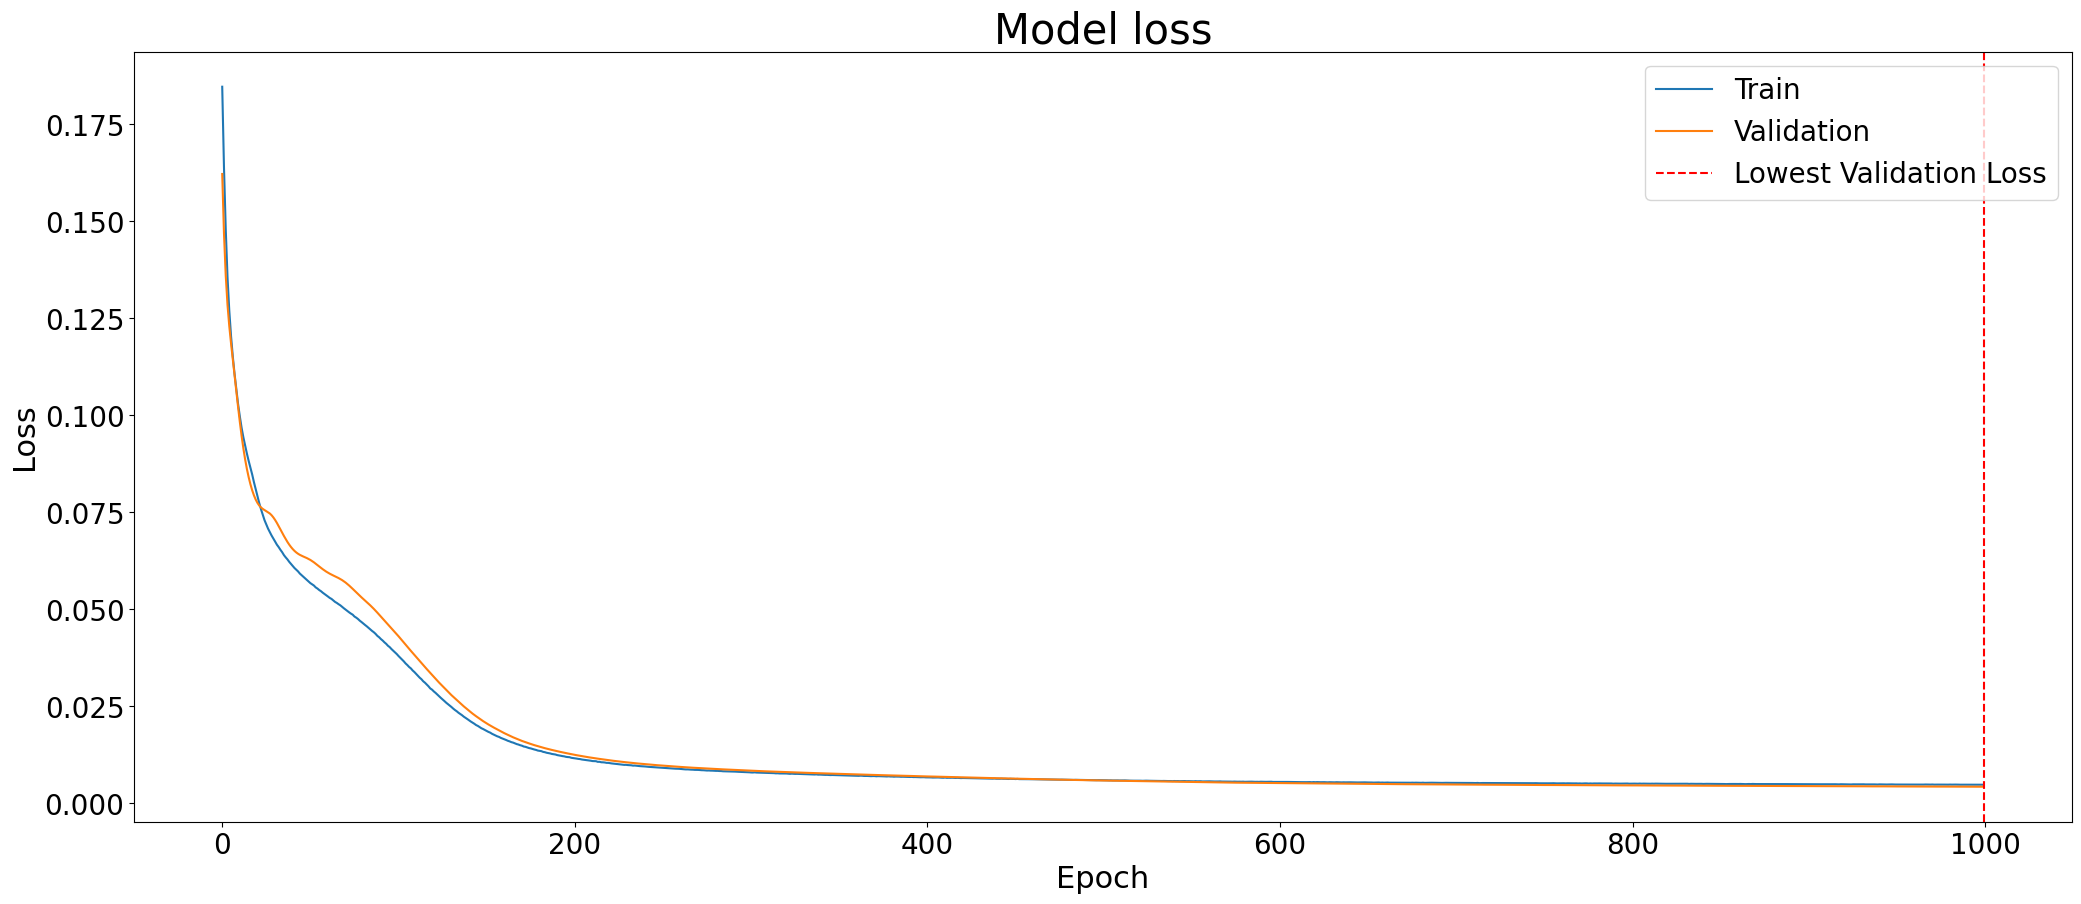

In [ ]:
# Plot model training & validation loss on the same plot
plot_file_name = f'24hr_virginia_key_wl_MLP_model_loss.png'

plot_model_loss(model_history, plot_file_name, legend_location = 'upper right')

### Plot time series of observations vs model predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


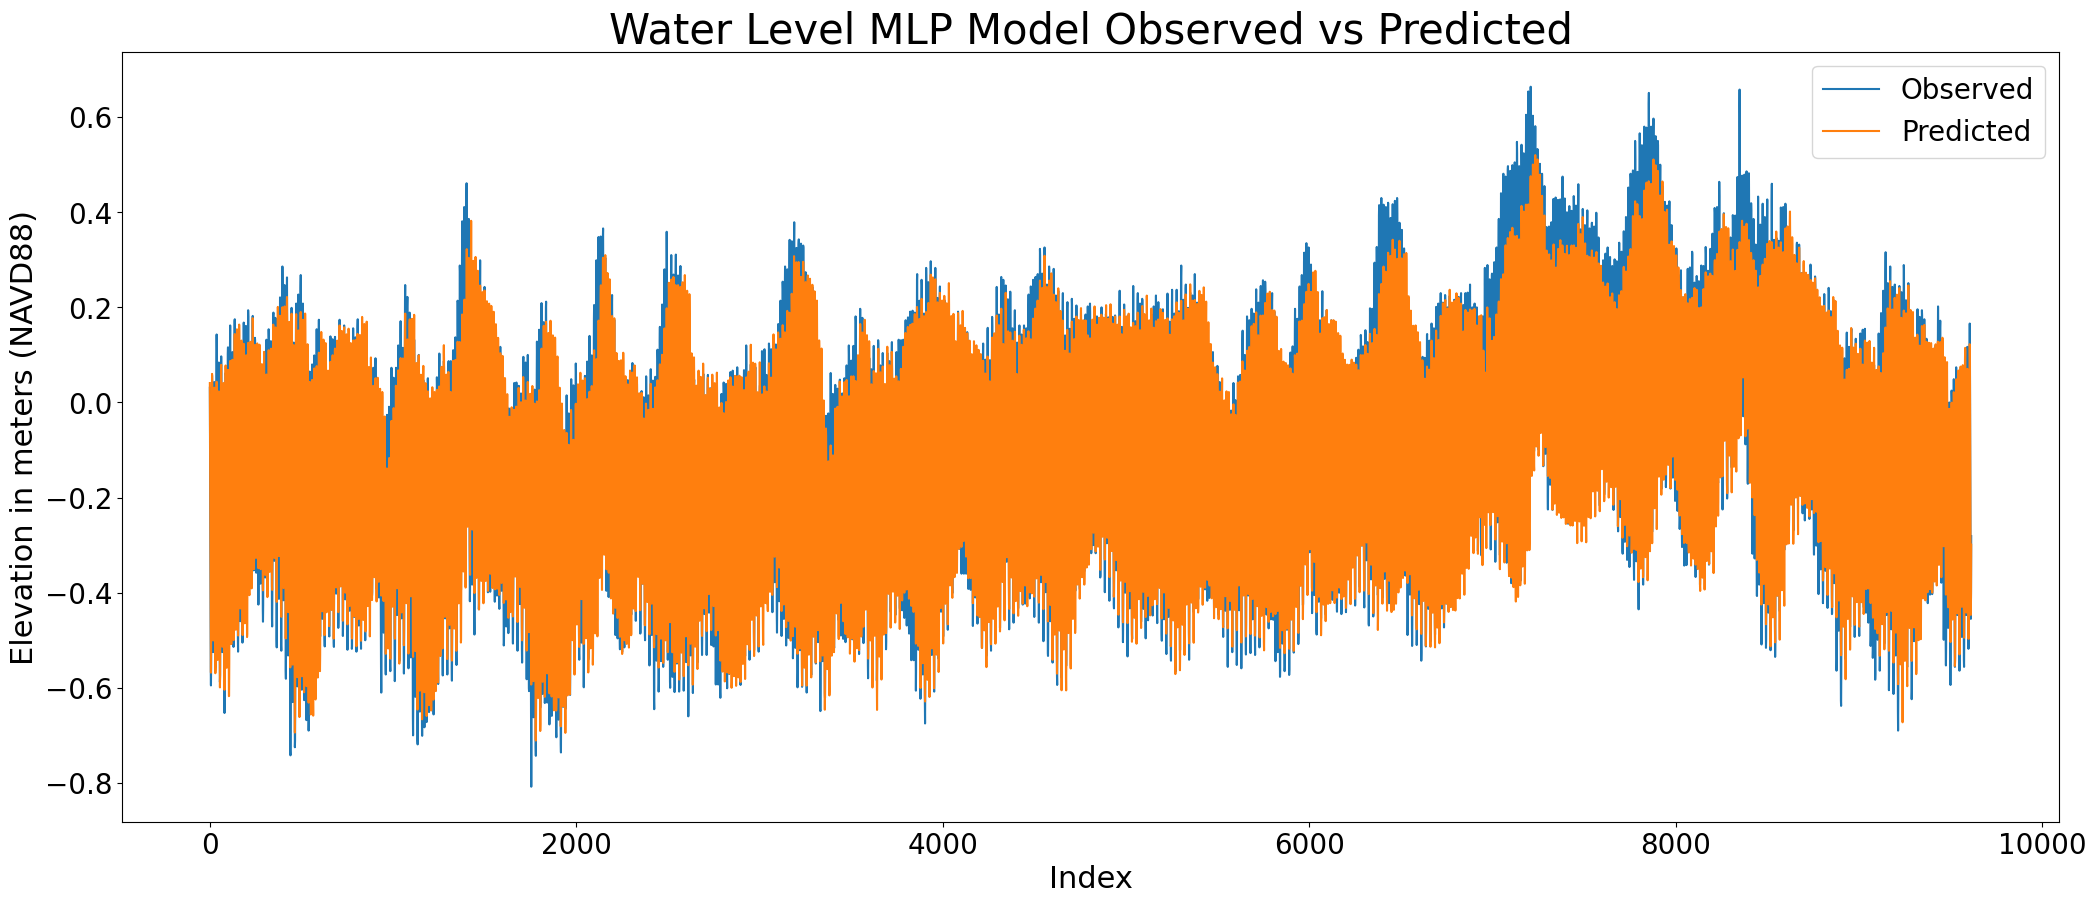

In [ ]:
# Plot observed vs predicted time series
predictions = model.predict(x_val, batch_size = len(x_val))
title = 'Water Level MLP Model Observed vs Predicted'
x_label = 'Index'
y_label = 'Elevation in meters (NAVD88)'
plot_file_name = f'24hr_virginia_key_wl_MLP_model_obsvspred.png'

plot_model_predictions(y_val, predictions, title, x_label, y_label, plot_file_name)

### Plot interactive chart
Here the actual datetimes are used on the x-axis. Part of the year 2019 was missing from the uwind/vwind datasets which is why there is that gap in the time series plot

In [ ]:
dfs_to_plot = []

datetime_index = validation_input_output_dict['datetime_index']

# Predictions
predictions_df = pd.DataFrame({'data': predictions.flatten()}, index = datetime_index)
predictions_df['dash_style'] = 'dash'
predictions_df['legend_label'] = 'Predicted'
predictions_df['line_color'] = 'orange'
dfs_to_plot.append(predictions_df)


# Observed
observed_df = pd.DataFrame({'data': y_val.flatten()}, index = datetime_index)
observed_df['dash_style'] = 'solid'
observed_df['legend_label'] = 'Observed'
observed_df['line_color'] = 'blue'
dfs_to_plot.append(observed_df)


# Plot
title = '24hr Water Level MLP Model Observed vs Predicted'
x_label = 'Datetime (UTC)'
y_label = 'Elevation in meters (NAVD88)'
plot_file_name = f'24hr_virginia_key_wl_MLP_model_obsvspred.html'
plot_interactive_time_series(dfs_to_plot, title, x_label, y_label, plot_file_name, show = True)

<ipython-input-6-23d72b4c0d76>:174: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



### Load in trained model
Once you save your model (using the ModelCheckpoint callback in this case) you can always load it back in using the `load_model` method from keras

In [ ]:
model_file_name = '24hr_virginia_key_wl_MLP_model.keras'
model = load_model(model_file_name)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (153408, 20)                │           1,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (153408, 20)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (153408, 1)                 │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,625 (18.07 KB)

 Trainable params: 1,541 (6.02 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,084 (12.05 KB)